In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from IPython.display import display
colour = ['#dc2624','#2b4750','#45a0a2','#e87a59','#7dcaa9'
,'#649E7D','#dc8018','#C89F91','#6c6d6c','#4f6268','#c7cccf']


import matplotlib
import sklearn
print('The current numpy version is ',np.__version__)
print('The current pandas version is ',pd.__version__)
print('The current matplotlib version is ',matplotlib.__version__)
print('The current seaborn version is ',sns.__version__)
print('The current sklearn version is ',sklearn.__version__)

The current numpy version is  1.19.0
The current pandas version is  1.0.5
The current matplotlib version is  3.2.2
The current seaborn version is  0.10.1
The current sklearn version is  0.23.1


In [2]:
#  处理之前的数据表格，也可不运行
game_1 = pd.read_csv('./GAME NARRATIVES (CSV 数字).csv')
game = game_1.iloc[1:,:]
game = game.drop(1)
# game_2 = pd.read_csv('./GAME NARRATIVES (CSV 文本).csv')
q_list = ['Game', 'Q1_1', 'Q1_2', 'Q1_3', 'Q2_1', 'Q2_2', 'Q2_3', 'Q3_1', 'Q3_2',
       'Q4_1', 'Q4_2', 'Q5_1', 'Q5_2', 'Q5_3', 'Q6_1', 'Q6_2']
data = game[q_list]
data.to_csv('./data.csv',index = None)

In [25]:
df = pd.read_csv('./data.csv')

In [26]:
# 删除有空值的数据，因为含有空值的数据不多，所以不需要填补，直接删除ji
df = df.dropna()
df.Game = df.Game.astype('int')
columns = df.columns[1:]

In [30]:
# 处理成功程度的表格
success = pd.read_excel('./Game Success 8.27 数字+英文名.xlsx')
map_score = {}

for  index,score in zip(success['Game Number'],success['Score']):
#     print(index,score)
    map_score[index] = score

In [32]:
df['score'] = df['Game'].map(map_score)
df = df.drop('Game',axis = 1)

### 这里使用交叉验证来保证模型的置信度（论文可写交叉验证原理等），我们使用4折交叉验证，模型使用了线性回归以及随机森林回归，衡量指标使用了mse和mae，分别统计了每轮的结果以及最终的结果

In [34]:
# 定义交叉验证的函数
def cross_validation(x,y):
    
        #生成DATAFRAm表格存储模型指标

    df_scores = []
    fold = StratifiedKFold(n_splits=4, shuffle=True)
    # n_splits 表示划分为几块（至少是2）
    # random_state 表示是否固定随机起点
    for index, (train_idx, val_idx) in enumerate(fold.split(x, y)):
        df_score = pd.DataFrame(np.zeros(shape=(2,3)))
        df_score.columns = ['evluation_indicator','RandomForestRegressor','LinearRegression']
        df_score.evluation_indicator = ['mse','mae']
        df_score.set_index('evluation_indicator',inplace=True)
        models = []
        val_list = []
    #     循环5次
    #     train_index表示skfold划分的其中五分之四的训练集的行索引
    #     val_idx表示skfold划分的其中五分之一的验证集的行索引
#         print('the {} round of cross validation'.format(index+1))
        train_x,train_y = x[train_idx], y[train_idx]
        val_x,val_y = x[val_idx], y[val_idx]
        
        rf = RandomForestRegressor()
        lr = LinearRegression()

        rf.fit(train_x,train_y)
        lr.fit(train_x,train_y)

        val_list.append(rf.predict(val_x))
        val_list.append(lr.predict(val_x))
        
        for i in range(len(val_list)):
            mse=metrics.mean_squared_error(val_y,val_list[i]) 
            mae=metrics.mean_absolute_error(val_y,val_list[i])

            df_score.iloc[0,i] = mse
            df_score.iloc[1,i] = mae

#             df_score.iloc[4,i] = recall

        df_scores.append(df_score)
        print('The {} round of cross validation : '.format(index+1))
        display(df_score)

    df_score_final = pd.DataFrame(np.zeros(shape=(2,3)))
    df_score_final.columns = ['evluation_indicator','RandomForestRegressor','LinearRegression']
    df_score_final.evluation_indicator = ['mse','mae']
    df_score_final.set_index('evluation_indicator',inplace=True)
#     将每轮交叉验证的结果送入list中，最终的结果取均值，增加统计上的可信度
    for df_score in df_scores:
        df_score_final = df_score_final+df_score
    df_score_final =  df_score_final/4
    
    print('The average resoult of cross validation : ')
    display(df_score_final.reset_index())
        
    return rf

In [35]:
x = df.drop('score',axis = 1).values
y = df.score.values
rf = cross_validation(x,y)

The 1 round of cross validation : 


,RandomForestRegressor,LinearRegression
evluation_indicator,,
mse,296.289248,309.930629
mae,14.931616,15.598468


The 2 round of cross validation : 


,RandomForestRegressor,LinearRegression
evluation_indicator,,
mse,276.914436,275.584663
mae,14.029563,14.854601


The 3 round of cross validation : 


,RandomForestRegressor,LinearRegression
evluation_indicator,,
mse,278.278100,287.061382
mae,14.241157,15.282391


The 4 round of cross validation : 


,RandomForestRegressor,LinearRegression
evluation_indicator,,
mse,283.275968,301.886224
mae,14.296676,15.632334


The average resoult of cross validation : 


,evluation_indicator,RandomForestRegressor,LinearRegression
0,mse,283.689438,293.615725
1,mae,14.374753,15.341948


### 由于线性回归模型无法判断特征的重要性程度，所以这里使用随机森林回归来得到特征的重要性程度，总结成表格，并绘制成图

In [36]:
# 定义获取特征重要性程度的函数
def get_importance(rf):
    df_feat = pd.DataFrame()
    df_feat['name'] = columns
    df_feat['score'] = rf.feature_importances_
    df_feat = df_feat.sort_values(['score'], ascending=False)

    display(df_feat)

    fig = plt.figure(figsize=(16,9), dpi = 100, facecolor='w', edgecolor='k')

    ax = fig.add_subplot(1,1,1)
    sns.barplot(df_feat['score'],df_feat['name'])
    plt.title('feature impotance',fontsize = 20)
    ax.set_yticklabels(labels=df_feat['name'])

    plt.show()

,name,score
12,Q5_3,0.085863
3,Q2_1,0.070647
7,Q3_2,0.070523
4,Q2_2,0.069330
11,Q5_2,0.068274
10,Q5_1,0.066822
14,Q6_2,0.066682
1,Q1_2,0.065482
9,Q4_2,0.064856
2,Q1_3,0.064786


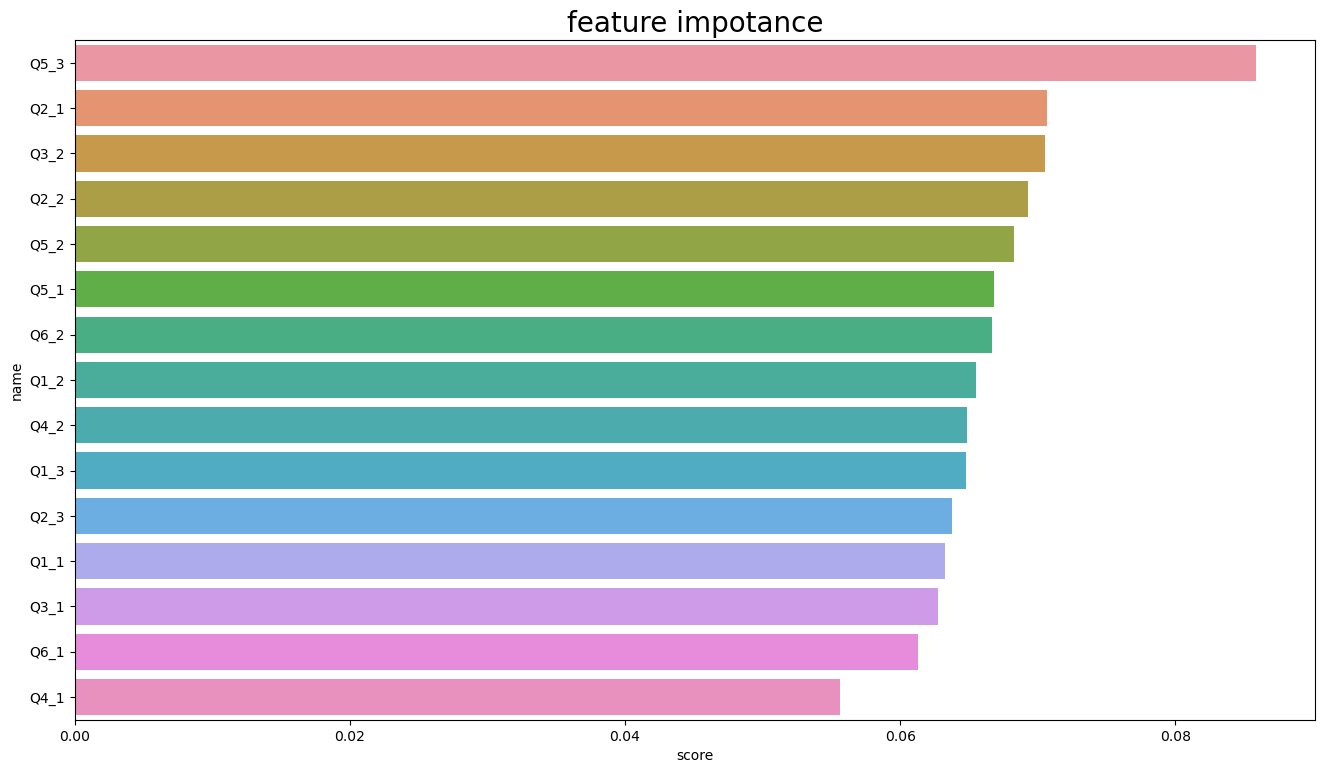

In [37]:
get_importance(rf)

In [ ]:
### 取15个问题的结果作为特征，这些问题的空缺都在20%以下，基本可以接受